In [94]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import graph_tool.all as gt



src_dir = os.path.abspath(os.path.join(os.pardir, 'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm

In [95]:
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

In [96]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
with open('../data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [98]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [99]:
all_movies.columns


Index(['AFI match', '_id', 'acting_all_gender_percentage',
       'acting_credited_gender_percentage', 'adjusted_budget', 'cast_all',
       'cast_credited', 'casting_directors', 'casting_gender_percentage',
       'cinematographers', 'cinematography_gender_percentage',
       'directing_gender_percentage', 'directors', 'genres', 'producers',
       'producing_gender_percentage', 'screenwriters', 'title',
       'writing_gender_percentage', 'year'],
      dtype='object')

In [100]:
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year', 'genres']]

In [101]:
movie_producer_df = movie_producer_df.sort_values('year')

In [102]:
movie_producer_df.head()

,_id,producers,producing_gender_percentage,title,year,genres
22884,tt0099622,"[[nm0000339, producer], [nm0515891, producer],...",33.333333,Full Fathom Five,1990,"[Action, Adventure]"
22502,tt0100822,"[[nm0135847, executive producer], [nm0275836, ...",0.000000,Tune in Tomorrow...,1990,"[Comedy, Romance]"
10973,tt0100935,"[[nm0326512, producer], [nm0474138, executive ...",0.000000,Wild at Heart,1990,"[Comedy, Crime, Drama, Thriller]"
22559,tt0099819,"[[nm0342045, executive producer], [nm0270288, ...",20.000000,I Love You to Death,1990,"[Comedy, Crime]"
24509,tt0099796,"[[nm0321860, line producer], [nm0711910, produ...",50.000000,Horseplayer,1990,"[Drama, Thriller]"


## Community detecton using graph_tool

In [103]:
movie_producer_df = movie_producer_df.set_index('_id')
movie_producer_dict = movie_producer_df.to_dict(orient='index')

In [104]:
movie_producer_dict['tt0099622']

{'producers': [['nm0000339', 'producer'],
  ['nm0515891', 'producer'],
  ['nm0560370', 'associate producer']],
 'producing_gender_percentage': 33.333333333333336,
 'title': 'Full Fathom Five',
 'year': 1990,
 'genres': ['Action', 'Adventure']}

### Make graph

## Stochastic block model

In [108]:
g = sgm.make_graph(movie_producer_dict)

In [109]:
clabel = g.vp['kind']
state = gt.minimize_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel})

In [110]:
state

<BlockState object with 2 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 7767 vertices and 10704 edges at 0x7f9eaf0aae10>, at 0x7f9eaf49b710>

In [111]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)

In [112]:
state.get_bs

<bound method NestedBlockState.get_bs of <NestedBlockState object, with base <BlockState object with 2 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 7767 vertices and 10704 edges at 0x7f9eaf0aae10>, at 0x7f9eaf813908>, and 2 levels of sizes [(7767, 2), (2, 1)] at 0x7f9eaf1bd240>>

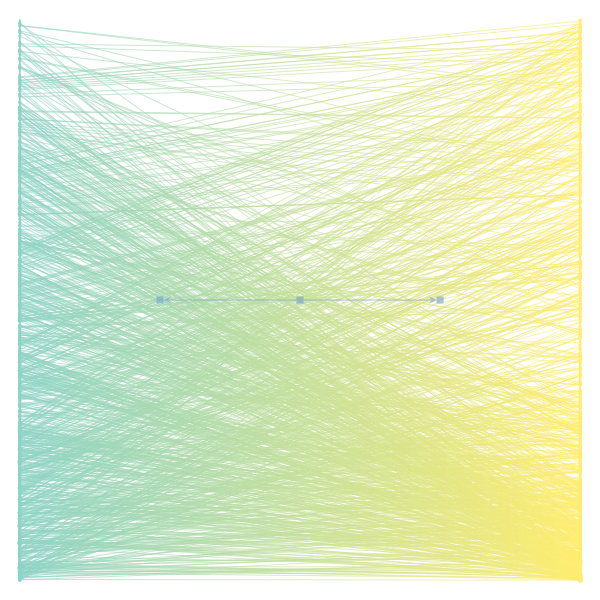

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9eaf0aae10, at 0x7f9eaf4bd128>,
 <Graph object, directed, with 7770 vertices and 7769 edges at 0x7f9eaf49b390>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9eaf49b390, at 0x7f9eaf813860>)

In [113]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1000,\
              hshortcuts=1, hide=0,\
              )

In [114]:
component = gt.label_largest_component(g)

sum(np.array(component.a))

6279

## giant component community

In [115]:
# g = make_graph(movie_producer_dict)
# del_list = []
# for v in g.vertices():
#     c = component[v]
#     if c == 0:
#         del_list.append(v)

In [116]:
# for v in reversed(sorted(del_list)):
#     g.remove_vertex(v)

In [117]:
# state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
# state

In [118]:
# gt.draw_hierarchy(state,layout='bipartite',\
#               output=None,\
#               subsample_edges=1000,\
#               hshortcuts=1, hide=0,\
#               )

## remove nodes with one edge

In [119]:
g = sgm.make_graph(movie_producer_dict)

In [120]:
one_degree_nodes = []
for v in g.vertices():
    edge_num = len(g.get_out_edges(v))
    if edge_num == 1:
        one_degree_nodes.append(v)

In [121]:
for v in reversed(sorted(one_degree_nodes)):
    g.remove_vertex(v)

In [122]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
state.entropy()

47950.94253332388

In [123]:
g.num_vertices()

3769

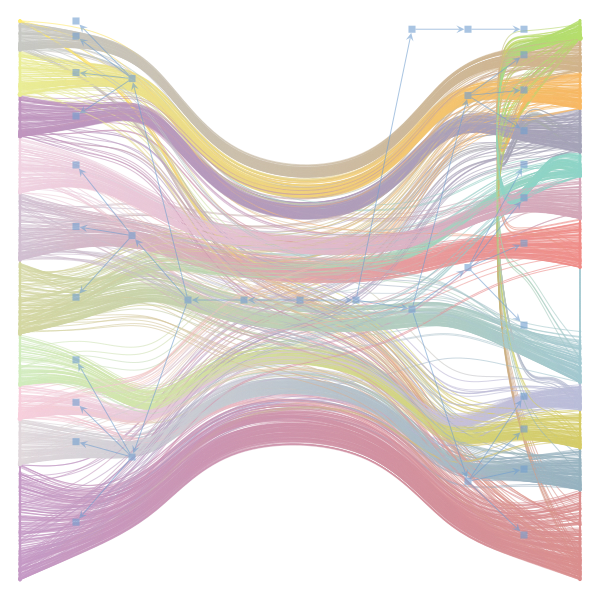

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9eaf33eba8, at 0x7f9eafc15780>,
 <Graph object, directed, with 3805 vertices and 3804 edges at 0x7f9eb0646c18>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9eb0646c18, at 0x7f9eafd124a8>)

In [124]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1500,\
              hshortcuts=1, hide=0,\
              beta=0.5
              )

In [125]:
state.entropy(), block_state.entropy()

(47950.94253332388, 48503.05026068828)

In [126]:
block_state = gt.minimize_blockmodel_dl(g, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)


In [127]:
block_state

<BlockState object with 19 blocks (19 nonempty), degree-corrected, for graph <Graph object, undirected, with 3769 vertices and 6751 edges at 0x7f9eaf33eba8>, at 0x7f9eb033fc50>

In [128]:
b = block_state.b
print(np.unique(np.array(b.a)))
i = 0
for v in g.vertices():
    print (g.vp['name'][v])
    print(b[v])
    i += 1
    if i == 100:
        break

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
tt0099622
0
tt0100822
0
tt0100935
0
tt0099819
0
tt0099796
1
tt0099371
0
tt0099044
0
tt0100606
2
tt0098987
0
tt0099052
0
tt0100602
0
tt0102703
1
tt0100212
0
tt0099316
0
tt0101812
0
tt0100240
0
tt0099739
0
tt0099740
0
tt0100129
0
tt0099841
3
tt0101328
2
tt0100814
0
tt0099253
0
tt0099969
3
tt0099817
4
tt0099348
0
tt0097115
3
tt0099108
3
tt0102744
4
tt0100258
5
tt0102170
3
tt0100224
6
tt0099623
4
tt0099750
7
tt0100157
5
tt0100802
6
tt0099710
3
tt0101596
3
tt0099578
7
tt0099762
3
tt0100200
4
tt0100404
2
tt0099423
7
tt0099856
3
tt0100911
8
tt0103035
5
tt0100691
6
tt0100046
6
tt0107284
4
tt0099012
9
tt0099832
3
tt0100480
8
tt0099365
2
tt0100613
2
tt0099800
2
tt0099374
7
tt0102330
3
tt0099088
0
tt0100065
8
tt0099153
3
tt0099039
2
tt0100791
9
tt0099017
2
tt0100171
2
tt0100994
0
tt0100318
0
tt0100135
2
tt0100828
5
tt0100530
5
tt0098994
3
tt0097994
7
tt0100201
0
tt0187067
3
tt0099128
3
tt0100050
4
tt0099121
3
tt0099810
4
tt0100114
7
tt010

## Genres 

In [130]:
genre_dict = list(movie_producer_df[['genres']].to_dict().values())[0]